In [1]:
import numpy as np
import matplotlib.pyplot as plt
import timeit
%matplotlib inline

In [8]:
from time import perf_counter


class PercolationSimulation:
    """
    A simulation of a 2D directed percolation problem. Given a 2D lattice, open sites
    are denoted by 0s, and blocked sites are denoted by 1s. During a simulation, water is
    poured into the top of the grid, and allowed to percolate to the bottom. If water
    fills a lattice site, it is marked with a 2 in the grid. Water only reaches a site
    if it reaches an open site directly above, or to the immediate left or right 
    of an open site.

    I've included the API for my solution below. You can use this as a starting point, 
    or you can re-factor the code to your own style. Your final solution must have a 
    method called percolate that creates a random lattice and runs a percolation 
    simulation and
    1. returns True if the system percolates
    2. stores the original lattice in self.grid
    3. stores the water filled lattice in self.grid_filled

    + For simplicity, use the first dimension of the array as the percolation direction
    + For boundary conditions, assume that any site out of bounds is a 0 (occupied)
    + You should use numpy for this problem, although it is possible to use lists 

    Attributes:
        grid (np.array): the original lattice of blocked (0) and open (1) sites
        grid_filled (np.array): the lattice after water has been poured in
        n (int): number of rows and columns in the lattice
        p (float): probability of a site being blocked in the randomly-sampled lattice
        random_state (int): random seed for numpy's random number generator. Used to 
            ensure reproducibility across random simulations. The default value of None
            will use the current state of the random number generator without resetting
            it.
    """

    def __init__(self, n=100, p=0.5, grid=None, random_state=None):
        """
        Initialize a PercolationSimulation object.

        Args:
            n (int): number of rows and columns in the lattice
            p (float): probability of a site being blocked in the randomly-sampled lattice
            random_state (int): random seed for numpy's random number generator. Used to
                ensure reproducibility across random simulations. The default value of None
                will use the current state of the random number generator without resetting
                it.
        """

        self.random_state = random_state # the random seed

        # Initialize a random grid if one is not provided. Otherwise, use the provided
        # grid.
        if grid is None:
            self.n = n
            self.p = p
            self.grid = np.zeros((n, n))
            self._initialize_grid()
        else:
            assert len(np.unique(np.ravel(grid))) <= 2, "Grid must only contain 0s and 1s"
            self.grid = grid.astype(int)
            # override numbers if grid is provided
            self.n = grid.shape[0]
            self.p = 1 - np.mean(grid)

        # The filled grid used in the percolation calculation. Initialize to the original
        # grid. We technically don't need to copy the original grid if we want to save
        # memory, but it makes the code easier to debug if this is a separate variable 
        # from self.grid.
        self.grid_filled = np.copy(self.grid)

    def _initialize_grid(self):
        """
        Sample a random lattice for the percolation simulation. This method should
        write new values to the self.grid and self.grid_filled attributes. Make sure
        to set the random seed inside this method.

        This is a helper function for the percolation algorithm, and so we denote it 
        with an underscore in order to indicate that it is not a public method (it is 
        used internally by the class, but end users should not call it). In other 
        languages like Java, private methods are not accessible outside the class, but
        in Python, they are accessible but access is discouraged by convention.

        Private methods are useful for functions that are necessary to support the 
        public methods (here, our percolate() method), but which we expect we might need
        to alter in the future. If we released our code as a library, others might 
        build software that accesses percolate(), and so we should not alter the 
        input/outputs because it's a public method
        """
        ###############################################################################

        np.random.seed(self.random_state) # Set the random seed
        self.grid = np.random.choice([0, 1], size=(self.n, self.n), p = [1-self.p, self.p])
        self.grid_filled = self.grid.copy()

        ###############################################################################
        

    def _flow_recursive(self, i, j):
        """
        Only used if we opt for a recursive solution.

        The recursive portion of the flow simulation. Notice how grid and grid_filled
        are used to keep track of the global state, even as our recursive calls nest
        deeper and deeper
        """
        #############################################################################

        if j != 0:
            if self.grid_filled[i,j-1] == 0: 
                self.grid_filled[i, j-1] = 2 
                PercolationSimulation._flow_recursive(self, i, j-1)
        if j != self.n - 1:
            if self.grid_filled[i,j+1] == 0:
                self.grid_filled[i,j+1] = 2
                PercolationSimulation._flow_recursive(self, i, j+1)
        if i != 0:
            if self.grid_filled[i-1, j] == 0:
                self.grid_filled[i-1, j] = 2
                PercolationSimulation._flow_recursive(self, i-1, j)
        if i != self.n - 1:
            if self.grid_filled[i+1, j] == 0:
                self.grid_filled[i+1, j] = 2
                PercolationSimulation._flow_recursive(self, i+1, j)

        if j != 0 and i != 0:
            if self.grid_filled[i-1,j-1] == 0:
                self.grid_filled[i-1,j-1] = 2
                PercolationSimulation._flow_recursive(self, i-1, j-1)
        if j != 0 and i != self.n-1:
            if self.grid_filled[i+1,j-1] == 0:
                self.grid_filled[i+1,j-1] = 2
                PercolationSimulation._flow_recursive(self, i+1, j-1)
        if j != self.n-1 and i != 0:
            if self.grid_filled[i-1,j+1] == 0:
                self.grid_filled[i-1,j+1] = 2
                PercolationSimulation._flow_recursive(self, i-1, j+1)
        if j != self.n-1 and i != self.n-1:
            if self.grid_filled[i+1,j+1] == 0:
                self.grid_filled[i+1,j+1] = 2
                PercolationSimulation._flow_recursive(self, i+1, j+1)   

        
        ###############################################################################s


    def _flow(self):
        """
        Run a percolation simulation using recursion

        This method writes to the grid and grid_filled attributes, but it does not
        return anything. In other languages like Java or C, this method would return
        void
        """
        ###############################################################################
        
        for j in range(0, self.n):
            if self.grid_filled[0,j] == 0:
                self.grid_filled[0,j] = 2
                PercolationSimulation._flow_recursive(self, 0, j)

        ###############################################################################


    def percolate(self):
        """
        Initialize a random lattice and then run a percolation simulation. Report results
        """
        ###############################################################################

        PercolationSimulation._initialize_grid(self)
        if 0 in self.grid[0, :]:
            PercolationSimulation._flow(self)
        
        if 2 in self.grid_filled[self.n-1, :]:
            return 1
        else:
            return 0
        
        ###############################################################################



1
1
0


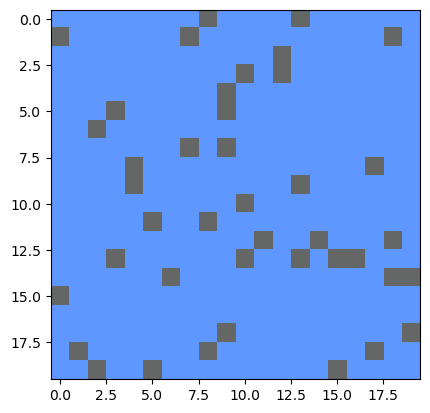

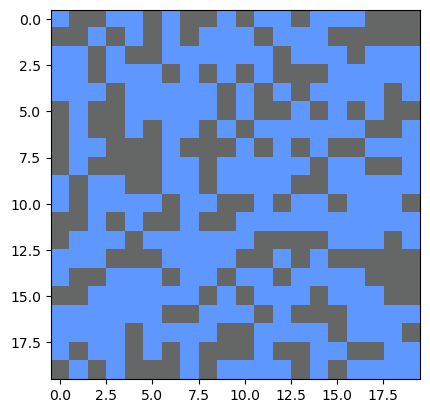

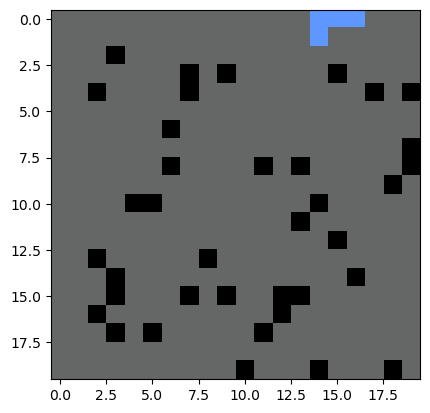

In [9]:
from matplotlib.colors import LinearSegmentedColormap
def plot_percolation(mat):
    """
    Plots a percolation matrix, where 0 indicates an empty site, 1 indicates a blocked 
    site, and 2 indicates a filled site
    """
    cvals  = [0, 1, 2]
    colors = [(0, 0, 0), (0.4, 0.4, 0.4), (0.372549, 0.596078, 1)]

    norm = plt.Normalize(min(cvals), max(cvals))
    tuples = list(zip(map(norm,cvals), colors))
    cmap = LinearSegmentedColormap.from_list("", tuples)
    plt.imshow(mat, cmap=cmap, vmin=0, vmax=2)


model = PercolationSimulation(n=20, random_state=0, p=0.1)
print(model.percolate())
plt.figure()
plot_percolation(model.grid_filled)

model = PercolationSimulation(n=20, random_state=0, p=0.4)
print(model.percolate())
plt.figure()
plot_percolation(model.grid_filled)

model = PercolationSimulation(n=20, random_state=0, p=0.9)
print(model.percolate())
plt.figure()
plot_percolation(model.grid_filled)

In [10]:
# Now we want to create a plot of the probability of percolating versus the grid size N

# First we need to again run our replicate simulations 
pvals = np.linspace(0, 1, 25) # control parameter for percolation phase transition
n_reps = 200 # number of times to repeat the simulation for each p value
N_vals = np.arange(10, 50, 5) # the grid sizes to run over

all_percolations_means = list()
# I added this list before I understood that the "variance" mentioned later is not meant to be the mathematical variance 
all_percolations_vars = list()

# for every N we'll run the replicate simulations
for N in N_vals:
    all_percolations = list()
    for P in pvals:
        all_replicates = list()
        for i in range(n_reps):
            # Initialize the model
            model = PercolationSimulation(N, p=P)
            all_replicates.append(model.percolate())
        all_percolations.append(all_replicates)
    all_percolations_means.append(np.mean(np.array(all_percolations), axis=1))
    all_percolations_vars.append(np.var(all_percolations))
    


Text(0, 0.5, 'Percolation probability')

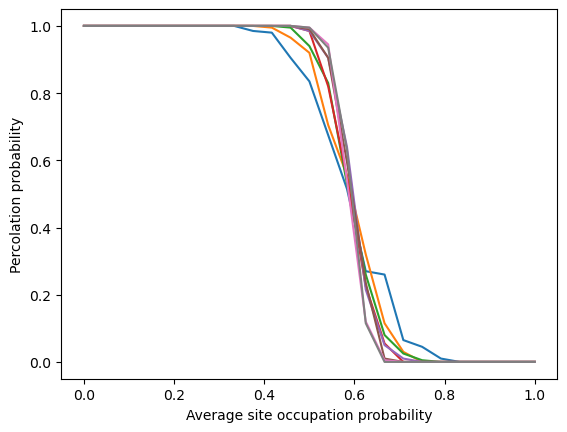

In [11]:
plt.figure()

for j in np.arange(0,len(N_vals)):
    plt.plot(pvals, all_percolations_means[j])

plt.xlabel('Average site occupation probability')
plt.ylabel('Percolation probability')

0
1
0
1
0
1
0
1
0
0


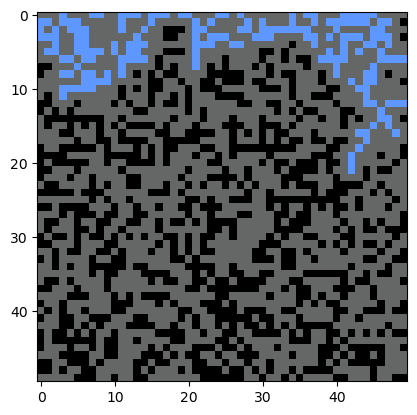

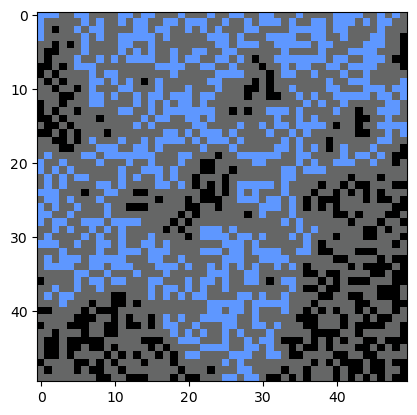

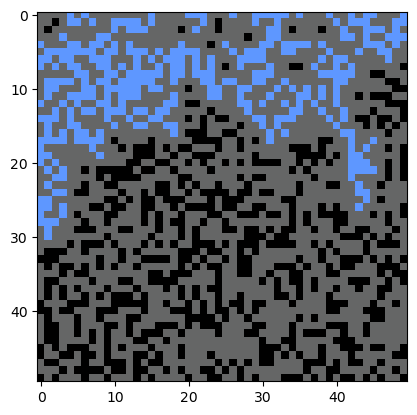

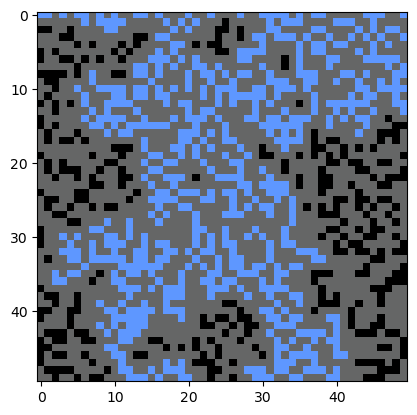

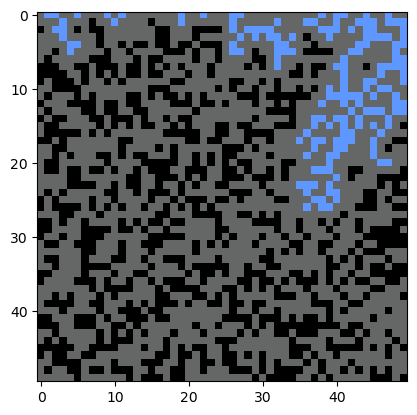

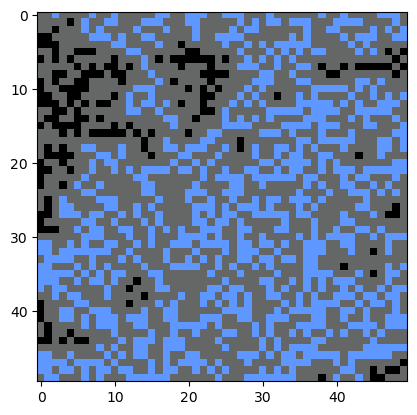

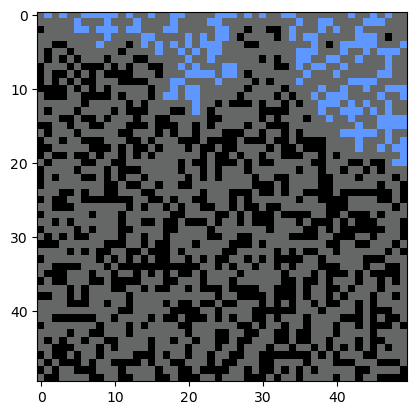

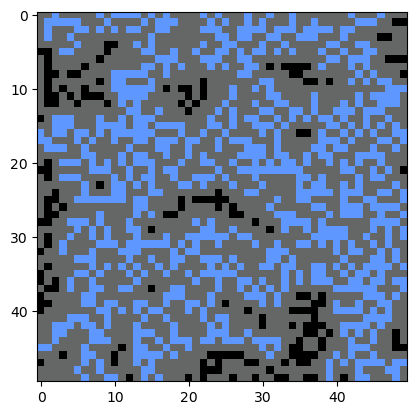

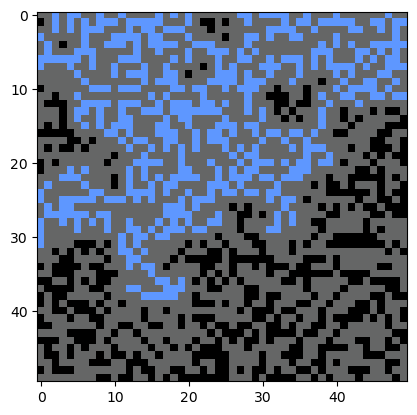

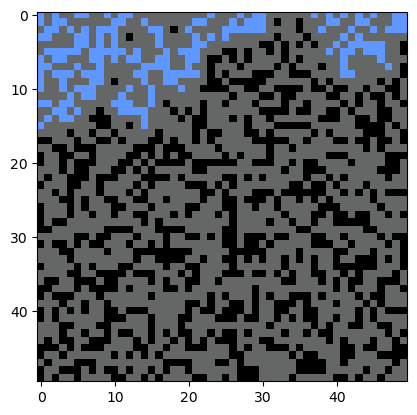

In [16]:
for j in np.arange(0,10):
    model = PercolationSimulation(n=50, p=0.6)
    print(model.percolate())
    plt.figure()
    plot_percolation(model.grid_filled)
